# Problem statement

## Context

  Company X owns a movie application and repository that caters to movie streaming to millions of users on a subscription basis. The company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on the cast information button, the app will show details of the actor in the scene. The company has in-house computer vision and multimedia experts who need to detect faces from screenshots of the movie scene.

## Objective

Part A: To build a face detection system

Part B: To create an image dataset to be used by the AI team to build image classifier data

Part C: To build a face recognition system

## Data Dictionary

Part A

label: Identifies the object in the image
notes: Additional comments (currently empty)
points: Co-ordinates of the mask (top-left and bottom-right)
imageWidth: Width of the image in pixels
imageHeight: Height of the image in pixels
Part B

The dataset comprises facial images that may contain either multiple individuals or a single individual per image.

Part C

This dataset consists of 10,770 images collected from Pinterest, featuring 100 individuals.

# Part - 1 Data Preprocessing and Visualization

## Installing and Importing libraries

In [1]:
!pip install -U tfds-nightly --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.5 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 24102, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 24102 (delta 55), reused 32 (delta 32), pack-reused 23981 (from 2)
Receiving objects: 100% (24102/24102), 44.21 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (13064/13064), done.


In [3]:
!cd examples

In [4]:
!mv examples/tensorflow_examples tensorflow_examples

In [5]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix ##  a module within the tensorflow_examples package that provides an implementation of the Pix2Pix model for image-to-image translation
tfds.disable_progress_bar() # This is called to disable the progress bar that is displayed by default when using the tensorflow_datasets package.

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = np.load('/content/drive/MyDrive/Computer Vision/Images.npy',allow_pickle=True)

In [8]:
print(data.shape)  # If it's an array
print(type(data))  # To check if it's a dict, tuple, etc.

(393, 2)
<class 'numpy.ndarray'>


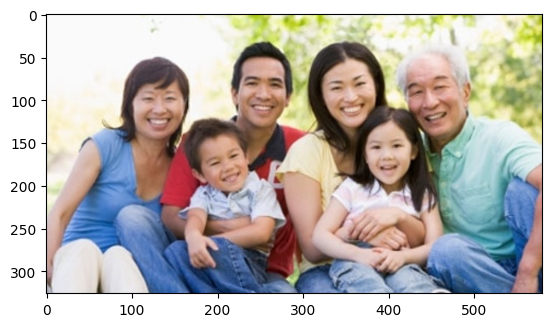

In [9]:
import matplotlib.pyplot as plt

# Visualize a sample
sample = data[3][0]  # Access the actual image data within the nested array
# If the image data is still an object, you may need to convert it to a NumPy array
if sample.dtype == 'object':
    sample = np.array(sample, dtype=np.uint8)  # Or another suitable dtype

plt.imshow(sample, cmap="gray")  # Display it
plt.show()

From the above observation of the data the data has images in the 0th column and the maska in the 1th column of the data

In [10]:
# Extract images and masks
images = data[:, 0]  # Extract the 0th column for images
masks = data[:, 1]  # Extract the 1st column for masks


In [15]:
print(type(images))
print(type(masks))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Skipping image with shape: (697, 1280, 4)
Skipping image with shape: (291, 600, 4)
Skipping image with shape: (340, 516, 4)
Skipping image with shape: (600, 800, 4)
Skipping image with shape: (312, 750, 4)
Skipping image with shape: (330, 538, 4)
Skipping image with shape: (496, 860, 4)
Skipping image with shape: (379, 505, 4)
Skipping image with shape: (400, 770, 4)
Skipping image with shape: (267, 740, 4)
Skipping image with shape: (281, 600, 4)


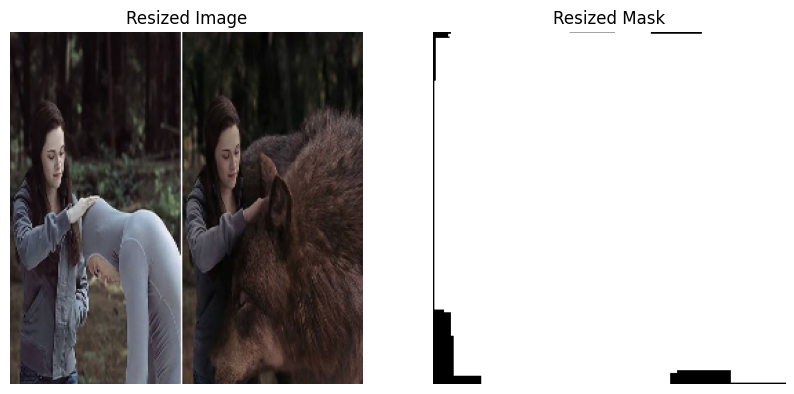

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the target size (height, width)
target_height = 256  # Example: new height
target_width = 256   # Example: new width
target_size = (target_width, target_height)

# Convert 'images' to a list of NumPy arrays if it contains objects
images_list = [np.array(img, dtype=np.uint8) for img in images]

# Resize each image in the list, ensuring consistent output shape
resized_images = []
for img in images_list:
    # If the image has 3 channels (likely RGB), resize directly
    if len(img.shape) == 3 and img.shape[2] == 3:
        resized_img = cv2.resize(img, target_size)
    # If the image has only 1 channel (likely grayscale),
    # convert to 3 channels before resizing
    elif len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        resized_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels
        resized_img = cv2.resize(resized_img, target_size)
    else:
        # Handle other cases if necessary
        print(f"Skipping image with shape: {img.shape}")
        continue  # Skip this image

    resized_images.append(resized_img)

# Stack the resized images into a single NumPy array
resized_image = np.stack(resized_images, axis=0)

# Now, let's handle the annotations and generate the mask (if needed)

mask = np.zeros((images_list[0].shape[0], images_list[0].shape[1]), dtype=np.uint8)  # Use the shape of the first image

# For each annotation, create a binary mask (bounding box or polygon) on the original mask
for annotation_list in masks:  # Iterate through the list of annotation lists
    for annotation in annotation_list:  # Iterate through individual annotations (dictionaries)
        if isinstance(annotation, dict) and 'points' in annotation:  # Check if it's a dictionary and has 'points'
            points = annotation['points']
            x1, y1 = int(points[0]['x'] * images_list[0].shape[1]), int(points[0]['y'] * images_list[0].shape[0])
            x2, y2 = int(points[1]['x'] * images_list[0].shape[1]), int(points[1]['y'] * images_list[0].shape[0])

            # Draw the bounding box (set the area to 1 for the foreground)
            cv2.rectangle(mask, (x1, y1), (x2, y2), 1, thickness=cv2.FILLED)

# Resize the mask to the target size
resized_mask = cv2.resize(mask, target_size)

# Show the resized image and mask
plt.figure(figsize=(10, 5))

# Show image
plt.subplot(1, 2, 1)
plt.imshow(resized_image[0]) # Display the first resized image
plt.title("Resized Image")
plt.axis('off')

# Show mask
plt.subplot(1, 2, 2)
plt.imshow(resized_mask, cmap='gray')
plt.title("Resized Mask")
plt.axis('off')

plt.show()

In [22]:
print(resized_image.shape)
print(resized_mask.shape)

(382, 256, 256, 3)
(256, 256)


In [23]:
from sklearn.model_selection import train_test_split

# Assuming you have a dataset in the form of (images, masks)
# You will separate the image data (X) and corresponding mask data (y)

X = [resized_image for image, _ in data]  # Images (list of numpy arrays)
y = [resized_mask for _, annotation in data]  # Annotations (list of masks or labels)


In [24]:

# Split the data into 80% for training and 20% for testing (adjust as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")


Training data size: 314
Testing data size: 79


In [25]:
print(X_train[0].shape)
print(y_train[0].shape)

(382, 256, 256, 3)
(256, 256)


# Part I: Model Building and Evaluation

In [28]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

# Define the target size (for resizing images)
target_size = (224, 224)  # Resize to 224x224 pixels

# Preprocess the training data (resize and normalize)
X_train_resized = []
for img in X_train:
    # Check if the image is valid before resizing
    if img is not None and img.size != 0:
        # Ensure img is 3D
        if len(img.shape) == 4:  # If it's 4D, take the first image in the batch
            img = img[0]
        resized_img = cv2.resize(img, target_size)
        X_train_resized.append(resized_img)
    else:
        print("Skipping invalid image")  # Print a message to identify skipped images

X_test_resized = []
for img in X_test:
    # Check if the image is valid before resizing
    if img is not None and img.size != 0:
        # Ensure img is 3D
        if len(img.shape) == 4: # If it's 4D, take the first image in the batch
            img = img[0]
        resized_img = cv2.resize(img, target_size)
        X_test_resized.append(resized_img)
    else:
        print("Skipping invalid image")  # Print a message to identify skipped images


# Convert images to numpy arrays and normalize to [0, 1]
X_train_resized = np.array([img_to_array(img) / 255.0 for img in X_train_resized])
X_test_resized = np.array([img_to_array(img) / 255.0 for img in X_test_resized])

# Define a function to extract label information (assuming it's available in 'data')
def get_label(annotation_data):
    """Extracts label information from the original 'data' array."""
    # This function needs to be adjusted based on the structure of your 'data' array
    # For example, if 'data' has a structure like this:
    # data = [[image_array, {'label': ['Face', ...], ...}], ...]
    # Then the function could be:
    try:
        return 1 if 'Face' in annotation_data[1]['label'] else 0
    except (IndexError, KeyError):  # Handle cases where the label might be missing
        return 0  # Or any other default value

# Convert annotations to binary labels using the get_label function
y_train = np.array([get_label(annotation_data) for annotation_data in data[y_train]]) # train_index from train_test_split
y_test = np.array([get_label(annotation_data) for annotation_data in data[y_test]]) # test_index from train_test_split

print("Train and Test data shapes:", X_train_resized.shape, X_test_resized.shape)

Train and Test data shapes: (314, 224, 224, 3) (79, 224, 224, 3)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Add first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of convolutional layers
model.add(Flatten())

# Add a fully connected (dense) layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output layer (1 neuron for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
print(X_train_resized.shape)
print(y_train.shape)
print(X_train_resized.shape)
print(y_train.shape)

(314, 224, 224, 3)
(314,)
(314, 224, 224, 3)
(314,)


In [31]:
# Train the model using the training data
history = model.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test),
                    epochs=10, batch_size=32)

# Save the trained model (optional)
model.save("face_mask_detection_model.h5")


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8363 - loss: 0.1937 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 1.0000 - loss: 7.1522e-31 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 1.00

In [32]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 615ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


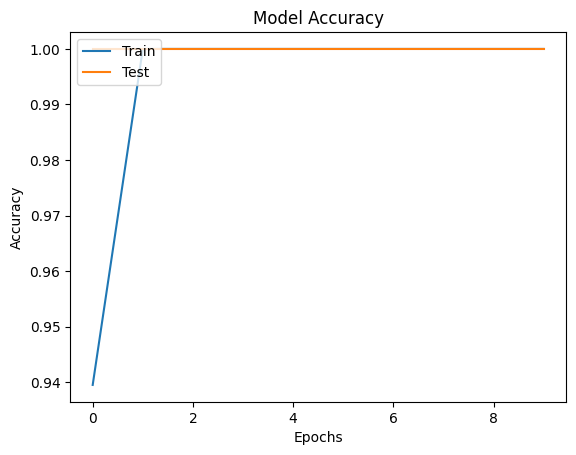

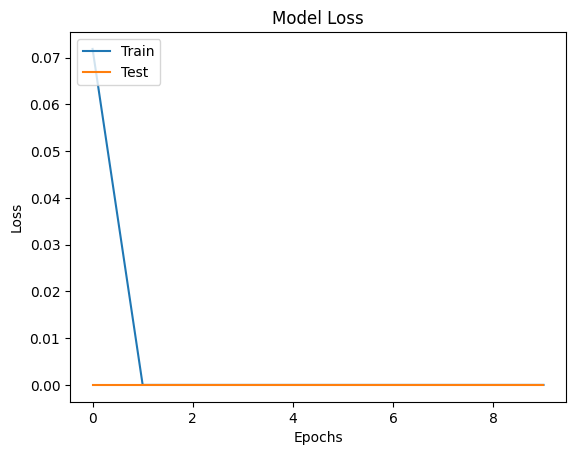

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [34]:
# Make predictions on the test images
predictions = model.predict(X_test_resized)

# Convert probabilities to binary labels (1 for "mask", 0 for "no mask")
predicted_labels = (predictions > 0.5).astype(int)

# Check the predicted labels
print("Predicted Labels:", predicted_labels)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step
Predicted Labels: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


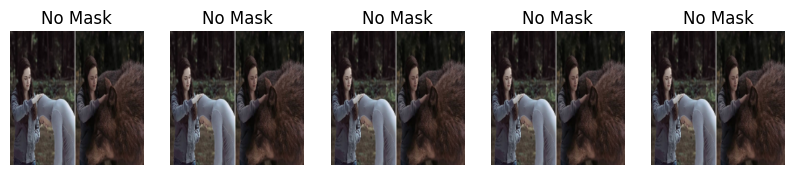

In [35]:
import matplotlib.pyplot as plt

# Plot a few test images along with their predicted labels
num_images = 5  # Number of images to display

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)

    # Display the test image
    plt.imshow(X_test_resized[i])  # Use X_test_resized for images

    # Add the title as the predicted label
    label = 'Mask' if predicted_labels[i] == 1 else 'No Mask'
    plt.title(label)
    plt.axis('off')  # Turn off axis

plt.show()


# Part I: Predicting Face Masks from Images

In [36]:
import cv2
import os
import numpy as np

# Define the directory where your images are stored
image_folder = '/content/drive/MyDrive/Computer Vision/training_images/training_images'

# List to store the images
image_list = []

# Iterate over all files in the folder
for file_name in os.listdir(image_folder):
    # Only process image files (e.g., .jpg, .png)
    if file_name.endswith('.jpg') or file_name.endswith('.png'):
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to a consistent shape
        img = img / 255.0  # Normalize to [0, 1]
        image_list.append(img)

# Convert the list to a numpy array
images = np.array(image_list)

print("Images shape:", images.shape)


Images shape: (1091, 224, 224, 3)


In [37]:
pip install opencv-python pandas


In [38]:
import cv2
import os
import pandas as pd
from pathlib import Path

# Initialize the face detector using Haar Cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize an empty list to store metadata
metadata_list = []

# Iterate over all image files in the folder
for img_path in Path(image_folder).glob("*.jpg"):  # Use "*.png" or "*.jpeg" for other formats
    # Read the image
    img = cv2.imread(str(img_path))

    # Convert the image to grayscale (Haar Cascade works on grayscale images)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If faces are found, store metadata
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            metadata_list.append({
                "image_filename": img_path.name,
                "face_x": x,
                "face_y": y,
                "face_width": w,
                "face_height": h,
                "num_faces": len(faces)
            })

# Create a DataFrame from the metadata list
df = pd.DataFrame(metadata_list)

# Save the DataFrame to a CSV file
df.to_csv('face_metadata.csv', index=False)

print("Metadata saved to face_metadata.csv")


Metadata saved to face_metadata.csv


# Part II: Data Preprocessing


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import zipfile
import os

# Define the path to your zip file
zip_file_path = '/content/drive/MyDrive/Computer Vision/training_images/PINS.zip'

# Define the extraction directory
extraction_path = '/content/drive/MyDrive/Computer Vision/training_images/Unziped_pins/'

# Check if the extraction path exists, if not, create it
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Contents extracted to {extraction_path}")


Contents extracted to /content/drive/MyDrive/Computer Vision/training_images/Unziped_pins/


In [44]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

# Define the extraction path
extraction_path = '/content/drive/MyDrive/Computer Vision/training_images/Unziped_pins/PINS/'

# Define the output CSV file for labels
output_csv = 'image_labels.csv'

# Initialize the CSV file with column headers
with open(output_csv, 'w') as f:
    f.write('image_path,label\n')

# Define a generator to process images on-the-fly
def process_images(extraction_path, output_csv):
    for folder_name in os.listdir(extraction_path):
        folder_path = os.path.join(extraction_path, folder_name)

        # Skip if it's not a directory
        if not os.path.isdir(folder_path):
            continue

        # Process each image in the folder
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)

            # Read and preprocess the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize to 224x224
            img = img / 255.0  # Normalize pixel values

            # Save the processed image to a new path
            processed_path = f'/content/processed_images/{folder_name}_{img_file}'
            os.makedirs(os.path.dirname(processed_path), exist_ok=True)
            np.save(processed_path, img)  # Save as .npy file to reduce memory usage

            # Write the label and processed path to the CSV
            with open(output_csv, 'a') as f:
                f.write(f'{processed_path},{folder_name}\n')

            # Yield the processed image and label if needed for further processing
            yield img, folder_name

# Process images and save them incrementally
for _ in process_images(extraction_path, output_csv):
    pass

# Inspect the CSV file
df = pd.read_csv(output_csv)
print(df.head())


                                          image_path            label
0  /content/processed_images/pins_Aaron Paul_Aaro...  pins_Aaron Paul
1  /content/processed_images/pins_Aaron Paul_Aaro...  pins_Aaron Paul
2  /content/processed_images/pins_Aaron Paul_Aaro...  pins_Aaron Paul
3  /content/processed_images/pins_Aaron Paul_Aaro...  pins_Aaron Paul
4  /content/processed_images/pins_Aaron Paul_Aaro...  pins_Aaron Paul


# Part II: Visualizing Similar Images

In [46]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load pretrained EfficientNet model (without the classification layer)
model = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet')

# Define the path to your image dataset
dataset_path = '/content/drive/MyDrive/Computer Vision/training_images/Unziped_pins/PINS/'

# Create a dictionary to store embeddings and labels
embeddings = {}
labels = []

# Process each image in the dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    # Skip if it's not a directory
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)

        # Load and preprocess the image
        img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Normalize according to EfficientNet

        # Generate embedding using the model
        embedding = model.predict(img_array, verbose=0)[0]

        # Save the embedding and label
        embeddings[img_path] = embedding
        labels.append(folder_name)

# Convert embeddings and labels to numpy arrays for saving
embedding_matrix = np.array(list(embeddings.values()))
label_array = np.array(labels)

# Save embeddings and labels
np.save('image_embeddings.npy', embedding_matrix)
np.save('image_labels.npy', label_array)

print("Embeddings and labels saved successfully!")


Embeddings and labels saved successfully!


In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
# Define a distance function (Euclidean or Cosine Distance)
def calculate_distance(embedding1, embedding2, metric='euclidean'):
    if metric == 'euclidean':
        return euclidean(embedding1, embedding2)
    elif metric == 'cosine':
        return 1 - cosine_similarity([embedding1], [embedding2])[0][0]

# Set a threshold (adjust based on your dataset)
THRESHOLD = 0.5  # Example for cosine distance (0-1 range)


In [48]:
df.image_path

,image_path
0,/content/processed_images/pins_Aaron Paul_Aaro...
1,/content/processed_images/pins_Aaron Paul_Aaro...
2,/content/processed_images/pins_Aaron Paul_Aaro...
3,/content/processed_images/pins_Aaron Paul_Aaro...
4,/content/processed_images/pins_Aaron Paul_Aaro...
...,...
10765,/content/processed_images/pins_zendaya_zendaya...
10766,/content/processed_images/pins_zendaya_zendaya...
10767,/content/processed_images/pins_zendaya_zendaya...
10768,/content/processed_images/pins_zendaya_zendaya...


# Part - 3 Model Building and Inference

In [49]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



# Apply PCA
n_components = 50  # Set the number of principal components
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Save the reduced embeddings
np.save('reduced_image_embeddings.npy', reduced_embeddings)

# Print explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {np.sum(explained_variance):.2f}")


Explained variance by each component: [0.15163472 0.12777281 0.05985077 0.03806631 0.03504859 0.03083817
 0.02278985 0.02203282 0.01973389 0.01814817 0.01642537 0.01516238
 0.01348606 0.01278257 0.01146004 0.01056247 0.00984774 0.00911177
 0.00859492 0.00790467 0.00748036 0.00703433 0.00682185 0.00648969
 0.00591489 0.0056525  0.00520078 0.00497147 0.00493749 0.00467362
 0.00446419 0.00438991 0.00433114 0.00416439 0.00404042 0.00381191
 0.00364083 0.003506   0.00345766 0.00342849 0.00332431 0.00320814
 0.00314639 0.00295741 0.00285956 0.00276218 0.0026371  0.00251378
 0.00246523 0.00244397]
Total explained variance: 0.77


In [50]:
from sklearn.model_selection import train_test_split


# Encode labels as integers (if needed)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_array)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    embedding_matrix, encoded_labels, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 8616
Test set size: 2154


In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the SVM classifier
svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # Use 'linear' or 'rbf' kernel

# Train the SVM classifier
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Test Accuracy: 35.75%

Classification Report:
                               precision    recall  f1-score   support

              pins_Aaron Paul       0.62      0.28      0.38        18
            pins_Alvaro Morte       0.85      0.48      0.61        23
             pins_Amanda Crew       0.39      0.32      0.35        28
          pins_Amaury Nolasco       0.62      0.33      0.43        24
               pins_Anna Gunn       0.75      0.60      0.67        10
    pins_Benedict Cumberbatch       0.50      0.07      0.12        14
            pins_Betsy Brandt       0.71      0.36      0.48        14
        pins_Brenton Thwaites       0.26      0.37      0.30        27
            pins_Brit Marling       0.38      0.50      0.43        18
          pins_Bryan Cranston       0.42      0.33      0.37        15
              pins_Caity Lotz       0.43      0.43      0.43        23
        pins_Cameron Monaghan       0.29      0.30      0.30        23
          pins_Chance Perdomo 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# Define a function to predict labels for new images
def predict_image_label(embedding, model, label_encoder):
    # Predict the label
    label_index = model.predict([embedding])[0]
    # Convert to original label
    return label_encoder.inverse_transform([label_index])[0]

# Example: Predict labels for the first 5 test embeddings
for i in range(5):
    predicted_label = predict_image_label(X_test[i], svm, label_encoder)
    actual_label = label_encoder.inverse_transform([y_test[i]])[0]
    print(f"Actual: {actual_label}, Predicted: {predicted_label}")


Actual: pins_Sarah Wayne Callies, Predicted: pins_Sarah Wayne Callies
Actual: pins_Brenton Thwaites, Predicted: pins_bellamy blake face
Actual: pins_Cobie Smulders, Predicted: pins_grant gustin face
Actual: pins_Wentworth Miller, Predicted: pins_Wentworth Miller
Actual: pins_millie bobby brown, Predicted: pins_barbara palvin face
